In [1]:
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cftime
from collections import OrderedDict

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

Set working directory to current working directory (needed to open SST observations and working with ARE). In a cell, enter and run:
```
%cd <path to the directory containing this recipe>
```

In [3]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37075/status,
Dashboard: /proxy/37075/status,Workers: 48
Total threads: 48,Total memory: 188.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36495,Workers: 48
Dashboard: /proxy/37075/status,Total threads: 48
Started: Just now,Total memory: 188.55 GiB
Comm: tcp://127.0.0.1:44155,Total threads: 1
Dashboard: /proxy/45761/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:46619,


Open the ACCESS-NRI default catalog:

In [4]:
catalog = intake.cat.access_nri

Define a function that opens a scalar variable for all cycles of each ACCESS-OM2 configuration and calculate an annual average. This function applies an offset to the time axis in order to append subsequent cycles:

In [5]:
def global_scalar(expt, variable, freq):
    cat_subset = catalog.search(name = expt)

    for idx, name in enumerate((sorted(cat_subset.keys()))[::-1]):
        darray = cat_subset[name].search(
            variable = variable,
            frequency = freq
        ).to_dask(xarray_open_kwargs=dict(
            use_cftime=True,
            chunks={"time":-1}
        ))[variable].load()
        if idx == 0:
            annual_average = darray.resample(time = '1YE').mean('time')
        else:
            tmp = darray.resample(time = '1YE').mean('time')
            last_year = tmp.time.values[-1].year
            first_year = annual_average.time.values[0].year
            offset = str(last_year - first_year + 1) + 'YE'
            tmp = tmp.assign_coords(time = tmp.time - xr.coding.cftime_offsets.to_offset(offset))
            annual_average = xr.concat([tmp, annual_average], dim='time')
    return annual_average

Load the variables (note how we have different frequencies available for different experiments):

In [6]:
temp_global_ave = {}
temp_global_ave['1deg'] = global_scalar('1deg_jra55_iaf_omip2_cycle?', 'temp_global_ave', '1mon')
temp_global_ave['025deg'] = global_scalar('025deg_jra55_iaf_omip2_cycle?', 'temp_global_ave', '1mon')
temp_global_ave['01deg'] = global_scalar('01deg_jra55v140_iaf.*', 'temp_global_ave', '1day')

In [7]:
temp_surface_ave = {}
temp_surface_ave['1deg'] = global_scalar('1deg_jra55_iaf_omip2_cycle?', 'temp_surface_ave', '1day')
temp_surface_ave['025deg'] = global_scalar('025deg_jra55_iaf_omip2_cycle?', 'temp_surface_ave', '1day')
temp_surface_ave['01deg'] = global_scalar('01deg_jra55v140_iaf.*', 'temp_surface_ave', '1day')

In [8]:
salt_surface_ave = {}
salt_surface_ave['1deg'] = global_scalar('1deg_jra55_iaf_omip2_cycle?', 'salt_surface_ave', '1day')
salt_surface_ave['025deg'] = global_scalar('025deg_jra55_iaf_omip2_cycle?', 'salt_surface_ave', '1day')
salt_surface_ave['01deg'] = global_scalar('01deg_jra55v140_iaf.*', 'salt_surface_ave', '1day')

In [9]:
ke_tot = {}
ke_tot['1deg'] = global_scalar('1deg_jra55_iaf_omip2_cycle?', 'ke_tot', '1mon')
ke_tot['025deg'] = global_scalar('025deg_jra55_iaf_omip2_cycle?', 'ke_tot', '1mon')
ke_tot['01deg'] = global_scalar('01deg_jra55v140_iaf.*', 'ke_tot', '1day')

Open SST observations:

In [10]:
temp = np.loadtxt('aravg.ann.ocean.90S.90N.v4.0.1.201901.asc')
sst = temp[:,1] + 18
sst_year = xr.cftime_range(start = '1880-07-01', periods = sst.size, 
                           freq = "A", calendar = "julian")
sst_year

CFTimeIndex([1880-12-31 00:00:00, 1881-12-31 00:00:00, 1882-12-31 00:00:00,
             1883-12-31 00:00:00, 1884-12-31 00:00:00, 1885-12-31 00:00:00,
             1886-12-31 00:00:00, 1887-12-31 00:00:00, 1888-12-31 00:00:00,
             1889-12-31 00:00:00,
             ...
             2010-12-31 00:00:00, 2011-12-31 00:00:00, 2012-12-31 00:00:00,
             2013-12-31 00:00:00, 2014-12-31 00:00:00, 2015-12-31 00:00:00,
             2016-12-31 00:00:00, 2017-12-31 00:00:00, 2018-12-31 00:00:00,
             2019-12-31 00:00:00],
            dtype='object', length=140, calendar='julian', freq='YE-DEC')

Create the plot

In [11]:
def add_cycles():
    cycle_dates = [1778, 1838, 1898]
    ylims=plt.gca().get_ylim()
    for cd in cycle_dates:
        plt.plot([cftime.datetime(cd,1,1),cftime.datetime(cd,1,1)],ylims,'k--',linewidth=0.8)
    plt.gca().set_ylim(ylims)

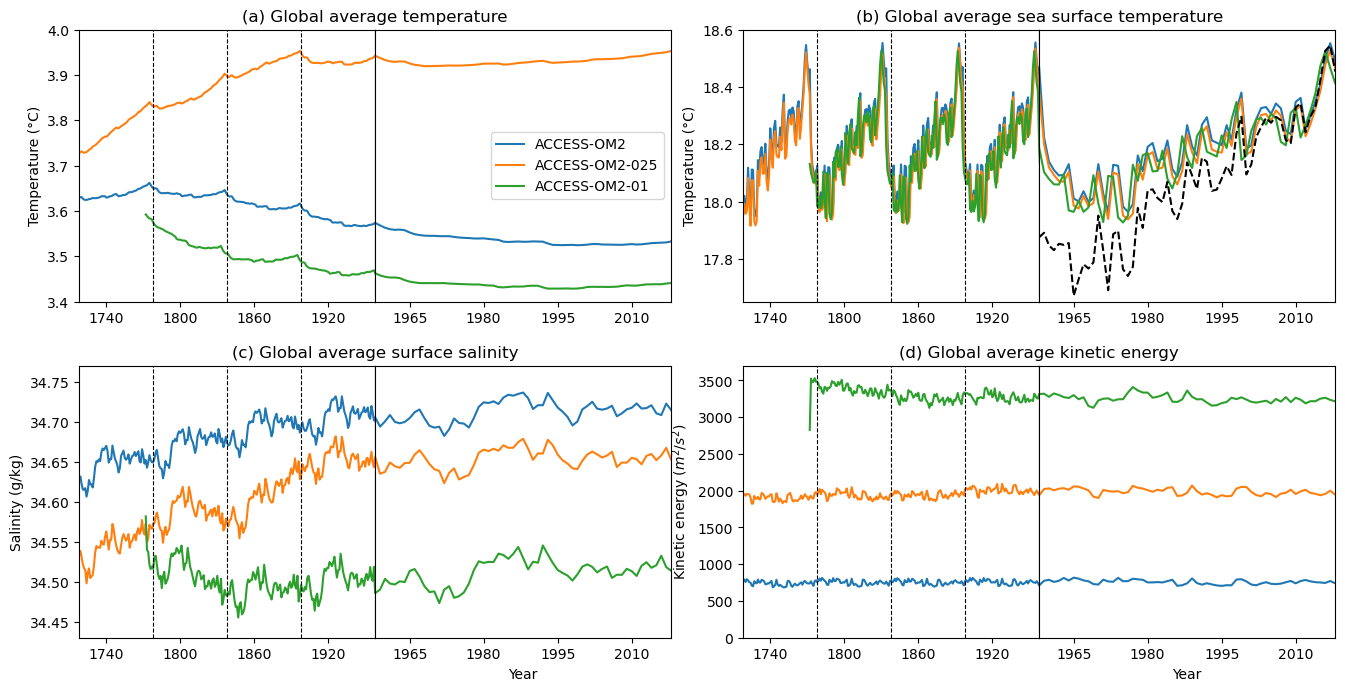

In [12]:
plt.figure(figsize=(16,8))

#############
## FIRST PLOT
ax = plt.axes([0.125, 0.545,0.185, 0.34])
temp_global_ave["1deg"].plot(ax=ax)
temp_global_ave["025deg"].plot(ax=ax)
temp_global_ave["01deg"].plot(ax=ax)
ax.set_title('')
plt.xlabel('')
plt.ylabel('Temperature (°C)')
ax.set_ylim([3.4, 4.0])
ax.set_xlim([cftime.datetime(1718,1,1),cftime.datetime(1957,12,31)])
#ax.set_xticks([cftime.datetime(1730,1,1), cftime.datetime(1740,1,1), cftime.datetime(1750,1,1), cftime.datetime(1770,1,1), 
#               cftime.datetime(1780,1,1), cftime.datetime(1790,1,1), cftime.datetime(1810,1,1), cftime.datetime(1820,1,1), 
#               cftime.datetime(1830,1,1), cftime.datetime(1850,1,1), cftime.datetime(1860,1,1), cftime.datetime(1870,1,1),
#               cftime.datetime(1890,1,1), cftime.datetime(1900,1,1), cftime.datetime(1910,1,1), cftime.datetime(1930,1,1),
#               cftime.datetime(1940,1,1), cftime.datetime(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.31, 0.545,0.185, 0.34])
ax.set_yticks([])
temp_global_ave["1deg"].plot(ax=ax, label='ACCESS-OM2')
temp_global_ave["025deg"].plot(ax=ax, label='ACCESS-OM2-025')
temp_global_ave["01deg"].plot(ax=ax, label='ACCESS-OM2-01')
plt.legend()
plt.xlabel('')
plt.ylabel('')
ax.set_title('(a) Global average temperature',position=(0.0,1.0))
ax.set_ylim([3.4, 4.0])
ax.set_xlim([cftime.datetime(1958,1,1),cftime.datetime(2017,12,31)])

##############
## SECOND PLOT
ax = plt.axes([0.54, 0.545,0.185, 0.34])
temp_surface_ave["1deg"].plot(ax=ax)
temp_surface_ave["025deg"].plot(ax=ax)
temp_surface_ave["01deg"].plot(ax=ax)
ax.set_title('')
plt.xlabel('')
plt.ylabel('Temperature (°C)')
ax.set_ylim([17.65, 18.6])
ax.set_xlim([cftime.datetime(1718,1,1),cftime.datetime(1957,12,31)])
#ax.set_xticks([cftime.datetime(1730,1,1), cftime.datetime(1740,1,1), cftime.datetime(1750,1,1), cftime.datetime(1770,1,1), 
#               cftime.datetime(1780,1,1), cftime.datetime(1790,1,1), cftime.datetime(1810,1,1), cftime.datetime(1820,1,1), 
#               cftime.datetime(1830,1,1), cftime.datetime(1850,1,1), cftime.datetime(1860,1,1), cftime.datetime(1870,1,1),
#               cftime.datetime(1890,1,1), cftime.datetime(1900,1,1), cftime.datetime(1910,1,1), cftime.datetime(1930,1,1),
#               cftime.datetime(1940,1,1), cftime.datetime(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.725, 0.545,0.185, 0.34])
ax.set_yticks([])
temp_surface_ave["1deg"].plot(ax=ax)
temp_surface_ave["025deg"].plot(ax=ax)
temp_surface_ave["01deg"].plot(ax=ax)
plt.xlabel('')
plt.ylabel('')
ax.set_title('(b) Global average sea surface temperature',position=(0.0,1.0))
ax.set_xlim([cftime.datetime(1958,1,1),cftime.datetime(2017,12,31)])
## Add Obs:
ax.plot(sst_year,sst,'k--')
ax.set_ylim([17.65, 18.6])


#############
## THIRD PLOT
ax = plt.axes([0.125, 0.125,0.185, 0.34])
salt_surface_ave["1deg"].plot(ax=ax)
salt_surface_ave["025deg"].plot(ax=ax)
salt_surface_ave["01deg"].plot(ax=ax)
ax.set_title('')
plt.xlabel('')
plt.ylabel('Salinity (g/kg)')
ax.set_ylim([34.43, 34.77])
ax.set_xlim([cftime.datetime(1718,1,1),cftime.datetime(1957,12,31)])
#ax.set_xticks([cftime.datetime(1730,1,1), cftime.datetime(1740,1,1), cftime.datetime(1750,1,1), cftime.datetime(1770,1,1), 
#               cftime.datetime(1780,1,1), cftime.datetime(1790,1,1), cftime.datetime(1810,1,1), cftime.datetime(1820,1,1), 
#               cftime.datetime(1830,1,1), cftime.datetime(1850,1,1), cftime.datetime(1860,1,1), cftime.datetime(1870,1,1),
#               cftime.datetime(1890,1,1), cftime.datetime(1900,1,1), cftime.datetime(1910,1,1), cftime.datetime(1930,1,1),
#               cftime.datetime(1940,1,1), cftime.datetime(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.31, 0.125,0.185, 0.34])
ax.set_yticks([])
salt_surface_ave["1deg"].plot(ax=ax)
salt_surface_ave["025deg"].plot(ax=ax)
salt_surface_ave["01deg"].plot(ax=ax)
plt.ylabel('')
ax.set_title('(c) Global average surface salinity',position=(0.0,1.0))
ax.set_xlabel('Year',position=(0.0,1.0))
ax.set_ylim([34.43, 34.77])
ax.set_xlim([cftime.datetime(1958,1,1),cftime.datetime(2017,12,31)])

#############
## FOURTH PLOT
ax = plt.axes([0.54, 0.125,0.185, 0.34])
ke_tot["1deg"].plot(ax=ax)
ke_tot["025deg"].plot(ax=ax)
ke_tot["01deg"].plot(ax=ax)
ax.set_title('')
plt.xlabel('')
plt.ylabel('Kinetic energy ($m^2/s^2$)')
ax.set_ylim([0, 3700])
ax.set_xlim([cftime.datetime(1718,1,1),cftime.datetime(1957,12,31)])
#ax.set_xticks([cftime.datetime(1730,1,1), cftime.datetime(1740,1,1), cftime.datetime(1750,1,1), cftime.datetime(1770,1,1), 
#               cftime.datetime(1780,1,1), cftime.datetime(1790,1,1), cftime.datetime(1810,1,1), cftime.datetime(1820,1,1), 
#               cftime.datetime(1830,1,1), cftime.datetime(1850,1,1), cftime.datetime(1860,1,1), cftime.datetime(1870,1,1),
#               cftime.datetime(1890,1,1), cftime.datetime(1900,1,1), cftime.datetime(1910,1,1), cftime.datetime(1930,1,1),
#               cftime.datetime(1940,1,1), cftime.datetime(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.725, 0.125,0.185, 0.34])
ax.set_yticks([])
ke_tot["1deg"].plot(ax=ax)
ke_tot["025deg"].plot(ax=ax)
ke_tot["01deg"].plot(ax=ax)
plt.ylabel('')
ax.set_title('(d) Global average kinetic energy',position=(0.0,1.0))
ax.set_xlabel('Year',position=(0.0,1.0))
ax.set_ylim([0, 3700])
_ = ax.set_xlim([cftime.datetime(1958,1,1),cftime.datetime(2017,12,31)])